# Notebook for Climate Data 

In [9]:
#import packages
import xarray as xr
import geopandas as gpd
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from shapely.geometry import Point
import common_paths

#Load Climate Modell 
data_pr = xr.open_dataset('../data/climate_model/PR_data_climatemodel.nc')
data_wind = xr.open_dataset('../data/climate_model/sfcWind_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r2i1p1_DWD-EPISODES2018_v1-r1_mon_200601-210012.nc')
data_tempmax = xr.open_dataset('../data/climate_model/tasmax_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r2i1p1_DWD-EPISODES2018_v1-r1_mon_200601-210012.nc')
#Datavariables
wind = data_wind.sfcWind
pr = data_pr.pr
tempmax = data_tempmax.tasmax


In [47]:
# Merge Datasets
# data_all = xr.merge([pr,tempmax,tempmean,tempmin,humid,wind], compat='override')
data_all = xr.merge([pr,tempmax,wind], compat='override')

# conflict in height is overrided
# save height values somewhere else

# Slicing Time and Space to 2024 and Germany
time_slice_start = "2024-01-16"
time_slice_end   = "2054-01-16"
rlon_slice_min   = -8
rlon_slice_max   = -1
rlat_slice_min   = -4
rlat_slice_max   = 6

data_all_sliced = data_all.sel(time=slice(time_slice_start,time_slice_end),
                              rlon=slice(rlon_slice_min, rlon_slice_max), rlat=slice(rlat_slice_min, rlat_slice_max))

# Datavariables
wind = data_all_sliced.sfcWind
pr = data_all_sliced.pr
tempmax = data_all_sliced.tasmax

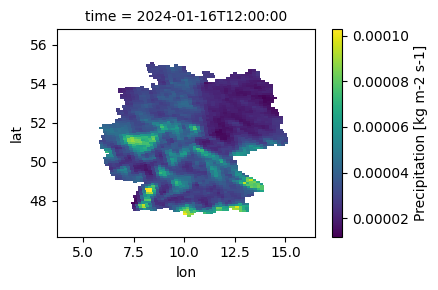

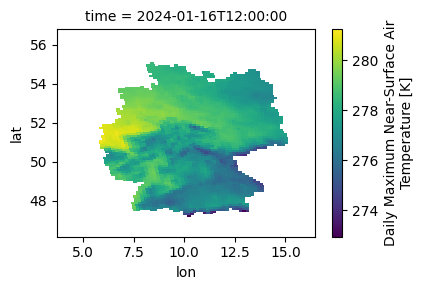

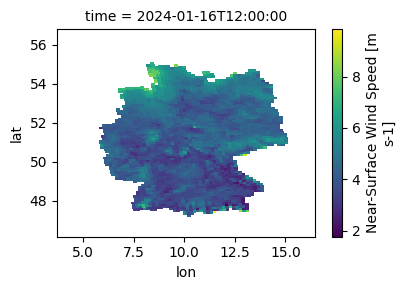

In [11]:
# Plot in Xarray 2024-01-16
data_all_sliced_plot = data_all_sliced.sel(time="2024-01-16")
variables = ['pr', 'tasmax', 'sfcWind']
units = [data_all.pr.attrs['units'], data_all.tasmax.attrs['units'],data_all.sfcWind.attrs['units']]
n_vars = len(variables)


for i, var in enumerate(variables):
    data_all_sliced_plot[var].plot(x="lon", y="lat", col="time")

['kg m-2 s-1', 'K', 'm s-1']


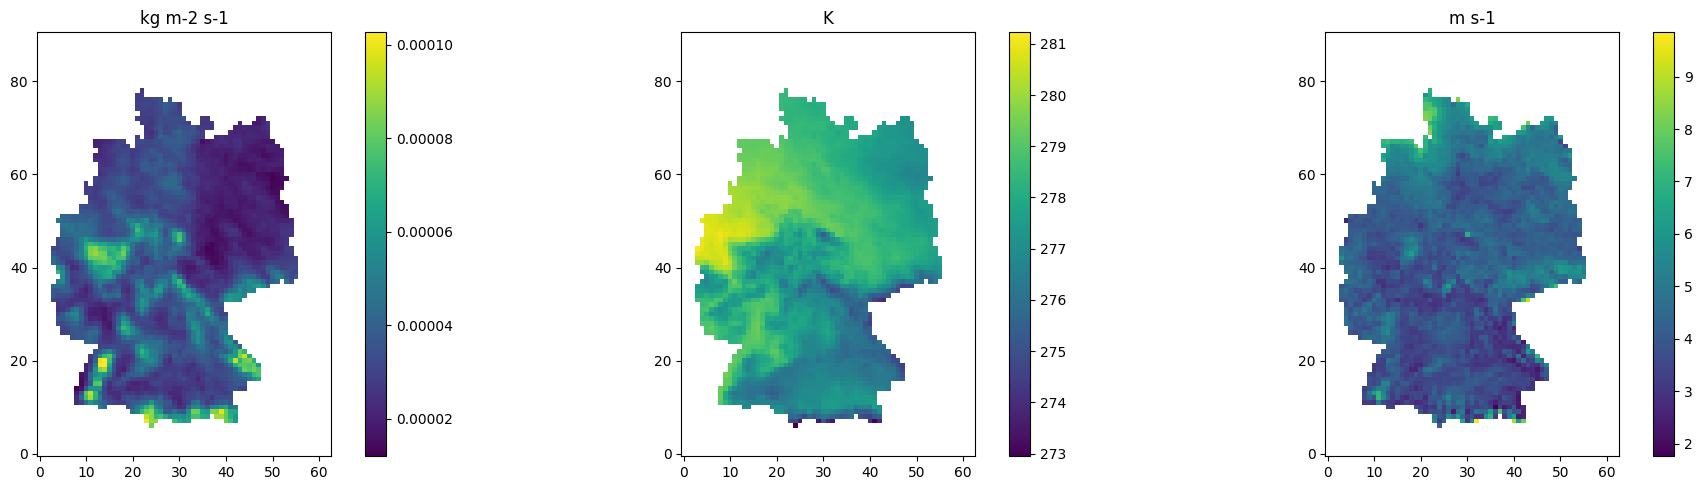

In [12]:
#Plot for with mathplotlib axes labeling not working

data_all_sliced_plot = data_all_sliced.sel(time="2024-01-16")

# Variablen, die geplottet werden sollen
variables = ['pr', 'tasmax', 'sfcWind']
units = [data_all.pr.attrs['units'], data_all.tasmax.attrs['units'], data_all.sfcWind.attrs['units']]
n_vars = len(variables)
print(units)
# Subplots erstellen
fig, axes = plt.subplots(nrows=1, ncols=n_vars, figsize=(20, 5))

for i, var in enumerate(variables):
    ax = axes[i]
    data = data_all_sliced_plot[var].squeeze()
    # Plotten der Daten als Bild mit imshow
    im = ax.imshow(data, cmap='viridis', origin='lower')
    ax.set_title(units[i])
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.tight_layout()
plt.show()

In [13]:
# Load Geometry Data from shape file 
path = '../data/cmip6/'
bundeslaender = gpd.GeoDataFrame.from_file(path + 'vg2500_geo84/vg2500_bld.shp')

# Extrahieren der lat und lon Werte und Umwandeln in eindimensionale Arrays
lat_values = data_all_sliced.lat.values.flatten().tolist()
lon_values = data_all_sliced.lon.values.flatten().tolist()

# Erstellen eines DataFrames mit den Koordinaten
dataframe_coords = pd.DataFrame({'lon': lon_values, 'lat': lat_values})

# Erstellen der Geometrie
dataframe_coords['coords'] = list(zip(dataframe_coords['lon'], dataframe_coords['lat']))
dataframe_coords['coords'] = dataframe_coords['coords'].apply(Point)
points = gpd.GeoDataFrame(dataframe_coords, geometry='coords', crs=bundeslaender.crs)

# Räumliche Verknüpfung der Punkte mit den Bundesländern
pointInPolys = gpd.tools.sjoin(points, bundeslaender, predicate="within", how='left')




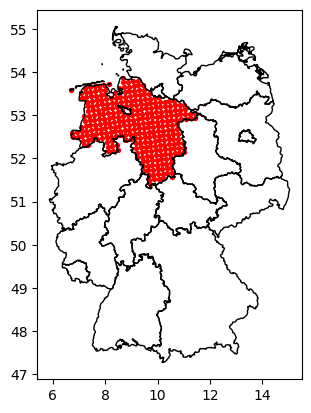

In [14]:
# Bundesland Vis aus Shape Datei 
points_niedersachsen = points[pointInPolys.GEN=='Niedersachsen']
points_bremen = points[pointInPolys.GEN=='Bremen']
base = bundeslaender.boundary.plot(linewidth=1, edgecolor="black")
#points.plot(ax=base, linewidth=1, color="blue", markersize=1)
points_niedersachsen.plot(ax=base, linewidth=1, color="red", markersize=8)
plt.show()  

In [15]:
## Add Bundesland Variable to Dataset -> calculate Bundesland for each point in dataset 

def find_nearest_indices(lat_array, lon_array, lat_value, lon_value):
    # Berechnung der Differenzen
    lat_diff = lat_array - lat_value
    lon_diff = lon_array - lon_value
    
    # Berechnung der Distanzen
    distance = np.sqrt(lat_diff**2 + lon_diff**2)
    #print(distance.shape)
    
    # Finden des Index mit dem kleinsten Abstand
    min_index = np.argmin(distance)
    #print(min_index)
    #print(lat_array.shape)
    # Entpacken der 2D-Indizes aus dem eindimensionalen Index
    lat_idx, lon_idx = np.unravel_index(min_index, lat_array.shape)
    #print(lat_array.shape)
    #print(lat_idx)
    #print(lon_idx)
    return int(lat_idx), int(lon_idx)


# Erstellen einer neuen Variable im Dataset
# Zuerst eine leere Variable initialisieren
bundesland_data = np.full((data_all_sliced.rlat.size, data_all_sliced.rlon.size), '', dtype='<U12')
bundesland_da = xr.DataArray(bundesland_data, coords=[data_all_sliced.rlat, data_all_sliced.rlon], dims=['rlat', 'rlon'])
print(bundesland_da.dims)

#Koordinaten Punkte mit Bundesländern versehen
for i, var in enumerate(bundeslaender.GEN):

    points_bundesland = points[pointInPolys.GEN == str(var)]
    print(f"Processing Bundesland: {var}")
    for idx, row in points_bundesland.iterrows():
        lat, lon = row['lat'], row['lon']
        #print("lat:",lat)
        lat_idx, lon_idx = find_nearest_indices(data_all_sliced.lat.values, data_all_sliced.lon.values, lat, lon)
        #print(f"Lat: {lat}, Lon: {lon} -> Lat_idx: {lat_idx}, Lon_idx: {lon_idx}")
        bundesland_da[lat_idx,lon_idx] = var
        
    #print[bundesland_da.values.tolist()]

data_all_sliced['Bundesland'] = bundesland_da
data_all_sliced.info()
# Überprüfen der hinzugefügten Variable
print(data_all_sliced['Bundesland'].values.tolist())


('rlat', 'rlon')
Processing Bundesland: Hamburg
Processing Bundesland: Niedersachsen
Processing Bundesland: Bremen
Processing Bundesland: Nordrhein-Westfalen
Processing Bundesland: Hessen
Processing Bundesland: Rheinland-Pfalz
Processing Bundesland: Baden-Württemberg
Processing Bundesland: Bayern
Processing Bundesland: Saarland
Processing Bundesland: Berlin
Processing Bundesland: Brandenburg
Processing Bundesland: Mecklenburg-Vorpommern
Processing Bundesland: Sachsen
Processing Bundesland: Sachsen-Anhalt
Processing Bundesland: Thüringen
Processing Bundesland: Schleswig-Holstein
xarray.Dataset {
dimensions:
	time = 361 ;
	rlat = 91 ;
	rlon = 63 ;

variables:
	datetime64[ns] time(time) ;
		time:standard_name = time ;
		time:long_name = time ;
		time:bounds = time_bnds ;
		time:axis = T ;
	float32 lon(rlat, rlon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
		lon:bounds = lon_bnds ;
	float32 lat(rlat, rlon) ;
		lat:standard_name = latitude

In [44]:
## Visualize Data to Bundesland 

# extract values for bundesland = all names of bundeslaender 
#base = bundeslaender.boundary.plot(linewidth=1, edgecolor="black")
bundeslaender = np.unique(data_all_sliced['Bundesland'].values)
# Delete first Entry which is ' ' -> also being a unique Value 
bundeslaender = bundeslaender[1:]
print(bundeslaender)
# different color of each bundesland 
farben = plt.get_cmap('tab10', len(bundeslaender))
farb_mapping = {bundesland: farben(i) for i, bundesland in enumerate(bundeslaender)}

# Daten plotten
plt.figure(figsize=(10, 6))
#print(bundeslaender)

bundesland_data = data_all_sliced['Bundesland'].values

# for bundesland in bundeslaender:
#     bundesland_mask = (bundesland_data == bundesland)

#     rlat_indices, rlon_indices = np.where(bundesland_mask)
#     rlat_values = data_all_sliced['rlat'].values[rlat_indices]
#     rlon_values = data_all_sliced['rlon'].values[rlon_indices]

#     # Erstelle eine neue Maske für das gesamte Dataset basierend auf rlat und rlon
#     plt.scatter(rlon_values, rlat_values, label=bundesland, color=farb_mapping[bundesland])

# plt.xlabel('rlat')
# plt.ylabel('rlon')
# plt.title('Plot der rlat und rlon nach Bundesland')
# plt.legend(title='Bundesland')
# plt.show()

['Baden-Württe' 'Bayern' 'Berlin' 'Brandenburg' 'Bremen' 'Hamburg'
 'Hessen' 'Mecklenburg-' 'Niedersachse' 'Nordrhein-We' 'Rheinland-Pf'
 'Saarland' 'Sachsen' 'Sachsen-Anha' 'Schleswig-Ho' 'Thüringen']


<Figure size 1000x600 with 0 Axes>

In [45]:
data_all_sliced.info()

xarray.Dataset {
dimensions:
	rlat = 91 ;
	rlon = 63 ;

variables:
	datetime64[ns] time() ;
		time:standard_name = time ;
		time:long_name = time ;
		time:bounds = time_bnds ;
		time:axis = T ;
	float32 lon(rlat, rlon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
		lon:bounds = lon_bnds ;
	float32 lat(rlat, rlon) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
		lat:bounds = lat_bnds ;
	float64 rlon(rlon) ;
		rlon:standard_name = grid_longitude ;
		rlon:long_name = longitude in rotated pole grid ;
		rlon:units = degrees ;
		rlon:axis = X ;
	float64 rlat(rlat) ;
		rlat:standard_name = grid_latitude ;
		rlat:long_name = latitude in rotated pole grid ;
		rlat:units = degrees ;
		rlat:axis = Y ;
	float32 pr(rlat, rlon) ;
		pr:standard_name = precipitation_flux ;
		pr:long_name = Precipitation ;
		pr:units = kg m-2 s-1 ;
		pr:grid_mapping = rotated_pole ;
		pr:cell_methods = time: mean ;
	float32

In [52]:
# 2 Dim array erste Dim bundesland zweite Dim für versch variablen ?
bundesland_pr_means = {}
wetter_all = []
for bundesland in bundeslaender:
    bundesland_mask = (bundesland_data == bundesland)

    # Create a new mask for the entire dataset based on rlat and rlon
    filtered_mask = xr.DataArray(
        bundesland_mask,
        dims=["rlat", "rlon"],
        coords={"rlat": data_all_sliced['rlat'], "rlon": data_all_sliced['rlon']}
    )

    # Apply the mask to the dataset and drop NaN values
    filtered_data = data_all_sliced.where(filtered_mask, drop=True)

    pr_df = filtered_data["pr"].to_dataframe().reset_index()
    pr_df["state"] = bundesland

    df_wind = filtered_data["sfcWind"].to_dataframe().reset_index()
    df_wind["state"] = bundesland

    df_temp_max = filtered_data["tasmax"].to_dataframe().reset_index()
    df_temp_max["state"] = bundesland

    wetter_all.append(pr_df)
    wetter_all.append(df_temp_max)
    wetter_all.append(df_wind)

# Merge the rest of the DataFrames
for df in wetter_all[1:]:
    common_columns = ["time", "rlat", "rlon", "state"]
    merge_columns = [col for col in df.columns if col not in common_columns]
    merged_df = pd.merge(
        merged_df, df, on=common_columns, how="outer", suffixes=("", "_dup")
    )

    # Drop duplicate columns created by the merge
    for col in merge_columns:
        if col + "_dup" in merged_df.columns:
            merged_df[col] = merged_df[col].combine_first(merged_df[col + "_dup"])
            merged_df.drop(columns=[col + "_dup"], inplace=True)

# merged_df.drop(columns=["lon_x","lat_x","height_x"], inplace=True)

In [54]:
merged_df

,rlat,rlon,time,pr,state,tasmax,sfcWind,lon,lat,height
0,-3.135,-5.715,2024-01-16 12:00:00,NaN,Bayern,NaN,NaN,9.570656,47.289349,2.0
1,-3.135,-5.605,2024-01-16 12:00:00,NaN,Bayern,NaN,NaN,9.731573,47.301716,2.0
2,-3.135,-5.495,2024-01-16 12:00:00,NaN,Bayern,NaN,NaN,9.892567,47.313850,2.0
3,-3.135,-5.385,2024-01-16 12:00:00,NaN,Bayern,NaN,NaN,10.053636,47.325745,2.0
4,-3.135,-5.275,2024-01-16 12:00:00,0.000088,Bayern,274.717743,3.103226,10.214778,47.337402,2.0
...,...,...,...,...,...,...,...,...,...,...
1547241,4.455,-4.395,2054-01-16 12:00:00,NaN,Schleswig-Ho,NaN,NaN,10.349719,54.977699,2.0
1547242,4.455,-4.285,2054-01-16 12:00:00,NaN,Schleswig-Ho,NaN,NaN,10.539841,54.988899,2.0
1547243,4.455,-4.175,2054-01-16 12:00:00,NaN,Schleswig-Ho,NaN,NaN,10.730063,54.999821,2.0
1547244,4.455,-4.065,2054-01-16 12:00:00,NaN,Schleswig-Ho,NaN,NaN,10.920385,55.010460,2.0


In [55]:
merged_df.drop(columns=["lon", "lat", "height"], inplace=True)

In [57]:
merged_df.dropna(inplace=True)

In [58]:
merged_df.to_csv(common_paths.OUTPUT_PATH.joinpath("DWD_future.csv"))

,rlat,rlon,time,pr,state,tasmax,sfcWind
4,-3.135,-5.275,2024-01-16 12:00:00,0.000088,Bayern,274.717743,3.103226
21,-3.135,-3.405,2024-01-16 12:00:00,0.000075,Bayern,272.946777,6.170968
31,-3.025,-5.275,2024-01-16 12:00:00,0.000087,Bayern,276.008057,3.912903
32,-3.025,-5.165,2024-01-16 12:00:00,0.000072,Bayern,275.440308,3.680645
36,-3.025,-4.725,2024-01-16 12:00:00,0.000058,Bayern,275.772583,4.490323
...,...,...,...,...,...,...,...
1547220,4.345,-5.055,2054-01-16 12:00:00,0.000031,Schleswig-Ho,274.869354,5.274194
1547221,4.345,-4.945,2054-01-16 12:00:00,0.000030,Schleswig-Ho,274.843536,4.612903
1547222,4.345,-4.835,2054-01-16 12:00:00,0.000030,Schleswig-Ho,274.804840,5.561290
1547232,4.455,-5.385,2054-01-16 12:00:00,0.000026,Schleswig-Ho,275.627411,6.209678


In [50]:
data_all_sliced.where(filtered_mask, drop=True)

<xarray.Dataset> Size: 849kB
Dimensions:  (time: 361, rlat: 13, rlon: 15)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2024-01-16T12:00:00 ... 2054-01-16T12:...
    lon      (rlat, rlon) float32 780B 10.09 10.26 10.43 ... 11.98 12.15 12.33
    lat      (rlat, rlon) float32 780B 50.2 50.22 50.23 ... 51.64 51.65 51.66
  * rlon     (rlon) float64 120B -5.055 -4.945 -4.835 ... -3.735 -3.625 -3.515
  * rlat     (rlat) float64 104B -0.275 -0.165 -0.055 ... 0.825 0.935 1.045
    height   float32 4B ...
Data variables:
    pr       (time, rlat, rlon) float32 282kB nan nan nan nan ... nan nan nan
    tasmax   (time, rlat, rlon) float32 282kB nan nan nan nan ... nan nan nan
    sfcWind  (time, rlat, rlon) float32 282kB nan nan nan nan ... nan nan nan
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    units:          kg m-2 s-1
    grid_mapping:   rotated_pole
    cell_methods:   time: mean

In [18]:
## Visualisierung der Durschnitte ? 

# data_all_sliced.info()
data_all_sliced = data_all_sliced.isel(time=1)
print(data_all_sliced)
bundesland_data = data_all_sliced['Bundesland'].values

for bundesland in bundeslaender:
    bundesland_mask = (bundesland_data == bundesland)
    
    # Erstelle eine neue Maske für das gesamte Dataset basierend auf rlat und rlon
    filtered_mask = xr.DataArray(
        bundesland_mask,
        dims=["rlat", "rlon"],
        coords={"rlat": data_all_sliced['rlat'], "rlon": data_all_sliced['rlon']}
    )

    # Wende die Maske auf das Dataset an und entferne NaN-Werte
    filtered_data = data_all_sliced.where(filtered_mask, drop=True)
    #precipitation_mean = filtered_data['pr'].mean(dim=["rlat", "rlon", "time"]).item()

    precipitation_mean = filtered_data['pr'].mean(dim=["rlat", "rlon"])
    precipitation_mean.plot(label=bundesland, color=farb_mapping[bundesland])

<xarray.Dataset> Size: 391kB
Dimensions:     (rlat: 91, rlon: 63)
Coordinates:
    time        datetime64[ns] 8B 2024-02-15T12:00:00
    lon         (rlat, rlon) float32 23kB 6.545 6.701 6.858 ... 15.82 16.01
    lat         (rlat, rlon) float32 23kB 46.23 46.25 46.27 ... 56.73 56.73
  * rlon        (rlon) float64 504B -7.915 -7.805 -7.695 ... -1.205 -1.095
  * rlat        (rlat) float64 728B -3.905 -3.795 -3.685 ... 5.775 5.885 5.995
    height      float32 4B ...
Data variables:
    pr          (rlat, rlon) float32 23kB ...
    tasmax      (rlat, rlon) float32 23kB ...
    sfcWind     (rlat, rlon) float32 23kB ...
    Bundesland  (rlat, rlon) <U12 275kB '' '' '' '' '' '' ... '' '' '' '' '' ''
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    units:          kg m-2 s-1
    grid_mapping:   rotated_pole
    cell_methods:   time: mean


TypeError: No numeric data to plot.